# Data Literacy Project – Analyzing the Similarity of Covid-19 Time Series Pattern
University of Tuebingen, Winter Term 2021/2022
#### Xuanhao Cao, Dorothee Sigg

In [194]:
import numpy as np
import pandas as pd
from datetime import datetime
from iso3166 import countries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tslearn.clustering as tsc
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw, soft_dtw, dtw_path
from math import floor, ceil, prod
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    softdtw_barycenter

In [195]:
# load covid data per country: weekly cases per million

url_wcpm = 'https://github.com/owid/covid-19-data/raw/master/public/data/jhu/weekly_cases_per_million.csv'
weekly_cases_full = pd.read_csv(url_wcpm)

#url_tdpm = 'https://github.com/owid/covid-19-data/raw/master/public/data/jhu/total_deaths_per_million.csv'
#total_deaths_per_million = pd.read_csv(url_tdpm)

# Inspect first few rows of the data
print('Number of rows (=days) in the dataframe: ', len(weekly_cases_full))
print('Number of columns (=countries) in the dataframe: ', len(weekly_cases_full.columns))
weekly_cases_full.head()

Number of rows (=days) in the dataframe:  744
Number of columns (=countries) in the dataframe:  230


,date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Yemen,Zambia,Zimbabwe
0,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
# preprocess: remove 'countries', which are not countries (e.g. 'high income')
if 'date' in weekly_cases_full.columns:
    weekly_cases_full = weekly_cases_full.set_index('date')

not_country = []
for col in weekly_cases_full.columns:
    if col not in countries: 
        not_country.append(col)
# print(not_country)
# hand-pick from that list
not_country = ['World', 'Africa', 'Asia', 'Europe', 'European Union', 'High income', 'International', 
               'Lower middle income', 'North America', 'Oceania', 'South America', 'Summer Olympics 2020', 
               'Upper middle income']

weekly_cases = weekly_cases_full.drop(not_country, axis=1)
print('Removed the following columns, because they are not a country:')
print(*not_country, sep = ", ")

Removed the following columns, because they are not a country:
World, Africa, Asia, Europe, European Union, High income, International, Lower middle income, North America, Oceania, South America, Summer Olympics 2020, Upper middle income


Interpolating: Removed 49 NaN values.


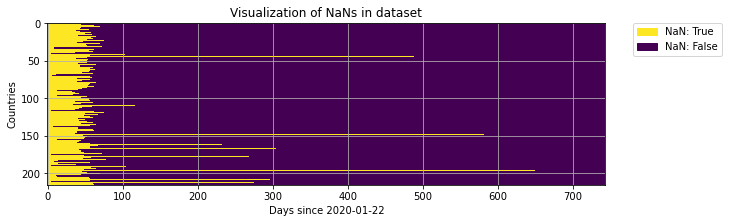

(744, 216)
Removed the following countries, because they have a lot of missing data:
Bonaire Sint Eustatius and Saba, Comoros, Cook Islands, Falkland Islands, Kiribati, Lesotho, Malawi, Marshall Islands, Micronesia (country), Palau, Saint Helena, Saint Pierre and Miquelon, Samoa, Sao Tome and Principe, Solomon Islands, South Sudan, Tajikistan, Tonga, Vanuatu, Wallis and Futuna, Yemen


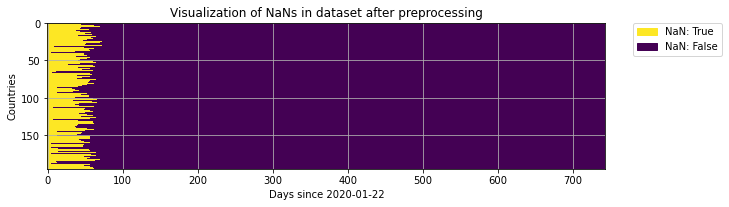

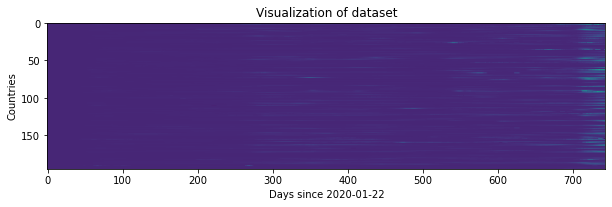

In [197]:
# preprocess: interpolate NaNs in the middle of timeseries
data_interpol = weekly_cases.apply(func=lambda x: x.interpolate())
print('Interpolating: Removed', weekly_cases.isna().sum().sum()-data_interpol.isna().sum().sum(), 'NaN values.')

# find out where the remaining NaNs are located
is_nan = data_interpol.isna()

plt.figure(figsize=(10,14))
im = plt.imshow(is_nan.T, interpolation='none')
colors = [ im.cmap(im.norm(b)) for b in [True, False]]
patches = [ mpatches.Patch(color=colors[i], label="NaN: {l}".format(l=[True, False][i]) ) for i in range(2) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(True)
plt.title('Visualization of NaNs in dataset')
plt.xlabel('Days since 2020-01-22')
plt.ylabel('Countries')
plt.show()


# if more than 10% data is missing, country is removed
print(data_interpol.shape)
missing_data_countries = data_interpol.isna().sum()/data_interpol.shape[0] > 0.1
remove_countries = missing_data_countries[missing_data_countries==True]
data_interpol = data_interpol.drop(remove_countries.index, axis=1)
print('Removed the following countries, because they have a lot of missing data:')
print(*remove_countries.index, sep= ", ")

# lets look at NaN visualization again
is_nan = data_interpol.isna()

plt.figure(figsize=(10,14))
im = plt.imshow(is_nan.T, interpolation='none')
colors = [ im.cmap(im.norm(b)) for b in [True, False]]
patches = [ mpatches.Patch(color=colors[i], label="NaN: {l}".format(l=[True, False][i]) ) for i in range(2) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.grid(True)
plt.title('Visualization of NaNs in dataset after preprocessing')
plt.xlabel('Days since 2020-01-22')
plt.ylabel('Countries')
plt.show()

# finally, replace NaNs at beginning of the timeseries with 0 
data = data_interpol.fillna(0)

plt.figure(figsize=(10,14))
plt.imshow(data.T)
plt.title('Visualization of dataset')
plt.xlabel('Days since 2020-01-22')
plt.ylabel('Countries')
plt.show()

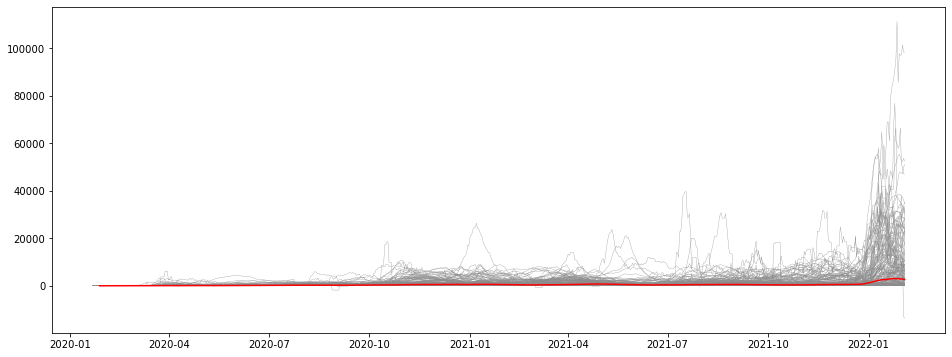

In [198]:
# plotting the cases for each country
dates = pd.to_datetime(data.index)
plt.figure(figsize=(16, 6))
plt.plot(dates, data, linewidth=0.3, color='0.55')
plt.plot(dates, weekly_cases_full['World'], color='r')
plt.show()

#### Look at a few single countries

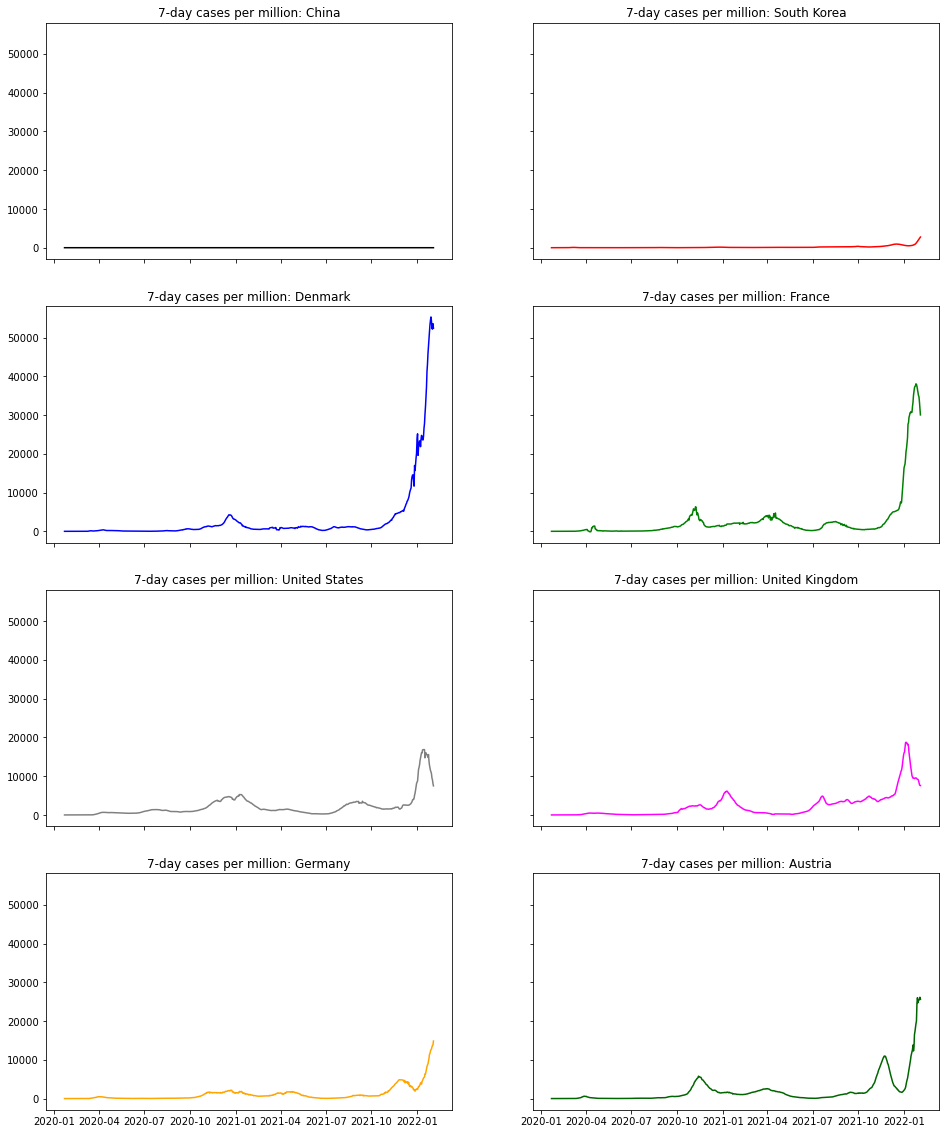

In [165]:
countries = ['China', 'South Korea', 'Denmark', 'France', 'United States', 'United Kingdom', 'Germany', 'Austria']
colors = ['black', 'red', 'blue', 'green', 'grey', 'magenta', 'orange', 'darkgreen']

fig, axs = plt.subplots(ceil(len(countries)/2), 2, sharex=True, sharey=True, figsize=(16, ceil(len(countries)/2)*5))

def axs_pos(x):
    fst = floor(x/2)
    if x % 2 == 0:
        snd = 0
    else:
        snd = 1
    return (fst, snd)

for i in range(len(countries)):
    axs[axs_pos(i)].plot(dates, data[countries[i]], color=colors[i])
    axs[axs_pos(i)].set_title(f'7-day cases per million: {countries[i]}')


In [166]:
similarities_dtw = pd.DataFrame(index=countries, columns=countries)
for c1 in countries:
    for c2 in countries:
        d = dtw(data[c1], data[c2])
        similarities_dtw[c1].loc[c2] = int(d)
print(similarities_dtw)

                 China South Korea Denmark  France United States  \
China                0        8999  233827  189274         96987   
South Korea       8999           0  214057  167887         69975   
Denmark         233827      214057       0   60809        153871   
France          189274      167887   60809       0        103540   
United States    96987       69975  153871  103540             0   
United Kingdom  106382       74600  167458  120038         10756   
Germany          60112       37616  144928   99051         23147   
Austria         111745       88573   98036   49227         52773   

               United Kingdom Germany Austria  
China                  106382   60112  111745  
South Korea             74600   37616   88573  
Denmark                167458  144928   98036  
France                 120038   99051   49227  
United States           10756   23147   52773  
United Kingdom              0   29816   58922  
Germany                 29816       0   41185  
Aus

In [167]:
similarities_eucl = pd.DataFrame(index=countries, columns=countries)

for c1 in countries:
    for c2 in countries:
        d = np.linalg.norm(data[c1]-data[c2])
        similarities_eucl[c1].loc[c2] = int(d)
print(similarities_eucl)

                 China South Korea Denmark  France United States  \
China                0        9009  233831  189304         97013   
South Korea       9009           0  226140  182437         90954   
Denmark         233831      226140       0   76125        164911   
France          189304      182437   76125       0        112294   
United States    97013       90954  164911  112294             0   
United Kingdom  106430       99819  172375  128325         48947   
Germany          60219       52149  181716  140633         60980   
Austria         111840      104369  148986  114536         76038   

               United Kingdom Germany Austria  
China                  106430   60219  111840  
South Korea             99819   52149  104369  
Denmark                172375  181716  148986  
France                 128325  140633  114536  
United States           48947   60980   76038  
United Kingdom              0   75018   91748  
Germany                 75018       0   55911  
Aus

In [168]:
print(similarities_dtw-similarities_eucl)

               China South Korea Denmark  France United States United Kingdom  \
China              0         -10      -4     -30           -26            -48   
South Korea      -10           0  -12083  -14550        -20979         -25219   
Denmark           -4      -12083       0  -15316        -11040          -4917   
France           -30      -14550  -15316       0         -8754          -8287   
United States    -26      -20979  -11040   -8754             0         -38191   
United Kingdom   -48      -25219   -4917   -8287        -38191              0   
Germany         -107      -14533  -36788  -41582        -37833         -45202   
Austria          -95      -15796  -50950  -65309        -23265         -32826   

               Germany Austria  
China             -107     -95  
South Korea     -14533  -15796  
Denmark         -36788  -50950  
France          -41582  -65309  
United States   -37833  -23265  
United Kingdom  -45202  -32826  
Germany              0  -14726  
Austri

Text(0.5, 1.0, 'Time series matching with DTW between Germany and Austria')

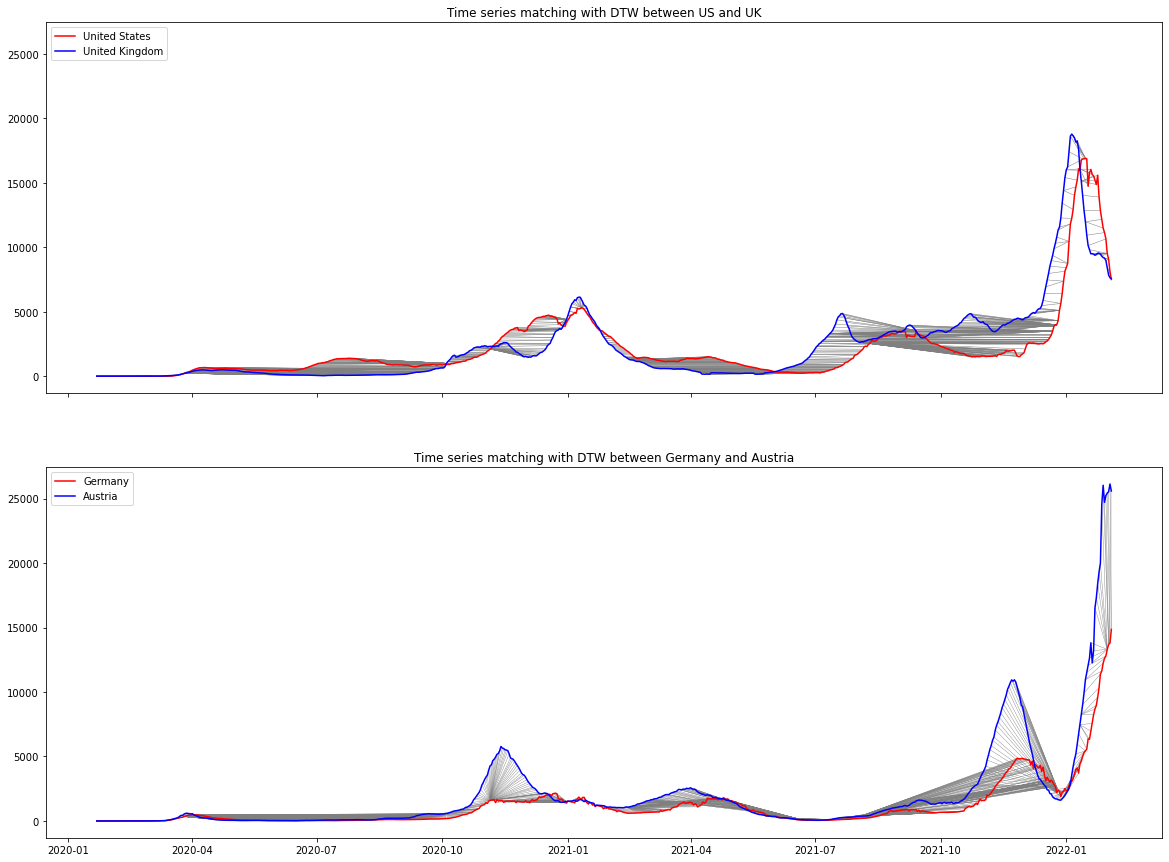

In [228]:
# DTW: lets take United States and United Kingdom as example
us = data['United States']
uk = data['United Kingdom']
ger = data['Germany']
aus = data['Austria']
path_1, dist_1 = dtw_path(us, uk)
path_2, dist_2 = dtw_path(ger, aus)


fig, axs = plt.subplots(2, 1, sharey=True, sharex=True, figsize=(20, 15))
for positions in path:
    axs[0].plot([dates[positions[0]], dates[positions[1]]],
                [us.iloc[positions[0]], uk.iloc[positions[1]]], color='grey', linewidth=0.5)
axs[0].plot(dates, us, "r-", label='United States', linewidth=1.5)
axs[0].plot(dates, uk, "b-", label='United Kingdom', linewidth=1.5)
axs[0].legend(loc='upper left')
axs[0].set_title("Time series matching with DTW between US and UK")
    
for positions in path:
    axs[1].plot([dates[positions[0]], dates[positions[1]]],
                [ger.iloc[positions[0]], aus.iloc[positions[1]]], color='grey', linewidth=0.4)
axs[1].plot(dates, ger, "r-", label='Germany', linewidth=1.5)
axs[1].plot(dates, aus, "b-", label='Austria', linewidth=1.5)
axs[1].legend(loc='upper left')
axs[1].set_title("Time series matching with DTW between Germany and Austria")


#plt.figure(1, figsize=(8, 8))
#plt.figure(figsize=(20,8))
#plt.plot(dates, us, "b-", label='United States')
#plt.plot(dates, uk, "g-", label='United Kingdom')
#
#for positions in path:
#    plt.plot([dates[positions[0]], dates[positions[1]]],
#             [us.iloc[positions[0]], uk.iloc[positions[1]]], color='grey', linewidth=0.7)
#
#plt.legend()
#plt.title("Time series matching with DTW between US and UK")
#plt.show()

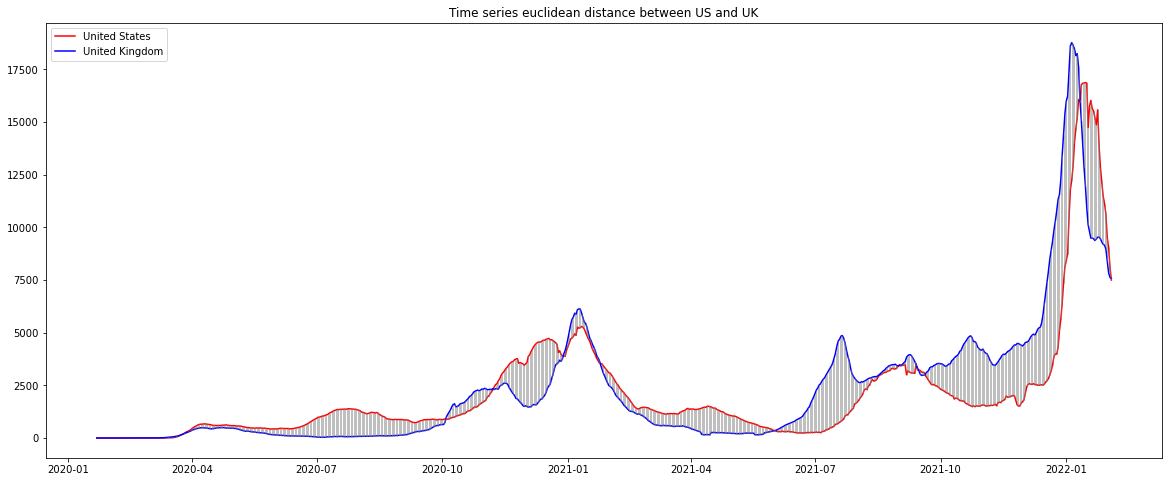

In [229]:
# EUCLIDEAN: lets take United States and United Kingdom as example

#plt.figure(1, figsize=(8, 8))
plt.figure(figsize=(20,8))
plt.plot(dates, us, "r-", label='United States')
plt.plot(dates, uk, "b-", label='United Kingdom')

for positions in range(len(dates)):
    plt.plot([dates[positions], dates[positions]],
             [us.iloc[positions], uk.iloc[positions]], color='grey', linewidth=0.5)

plt.legend()
plt.title("Time series euclidean distance between US and UK")
plt.show()

#### Using TimeSeriesKMeans algorithm

In [171]:
# first use europe countries only
#from countrygroups import EUROPEAN_UNION
import pycountry_convert as pc


#data_eu = pd.DataFrame(data[[c for c in data.columns if c in EUROPEAN_UNION.names]])
#print(len(data_eu.columns))
#data_eu = data_eu.T
#print(data_eu.shape)

def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

country_continent_dict = {}
for c in data.columns: 
    try:
        country_continent_dict[c] = country_to_continent(c)
    except:
        country_continent_dict[c] = 'undefined'
    
europe_countries = [k for k, v in country_continent_dict.items() if v == 'Europe']
print(len(europe_countries))

data_eu = pd.DataFrame(data[[c for c in data.columns if c in europe_countries]])
data_eu = data_eu.T
print(data_eu.shape)

45
(45, 744)


In [156]:
# continents
data_cont = weekly_cases_full[['Europe', 'Asia', 'Africa', 'North America', 'South America', 'Oceania']]
data_cont = data_cont.fillna(0)
data_cont = data_cont.T
print(data_cont.shape)

(6, 743)


In [209]:
dataset = data_eu

In [210]:
# using time series k-means algorithm
n_clusters = 3
metric = 'euclidean'

model = tsc.TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=50)
km = model.fit_predict(dataset)
print(km)
print(len(km))


[0 1 0 0 2 0 0 0 0 1 0 0 1 0 1 2 0 2 2 2 2 0 2 0 2 0 0 2 2 2 0 2 0 1 0 0 1
 0 0 1 2 2 2 0 2]
45


In [211]:
# compute silhouette score (-1 for incorrect clustering and +1 for highly dense clustering)
sc = tsc.silhouette_score(dataset, km, metric=metric)
print('silhouette score:', sc)

silhouette score: 0.24022657607153208


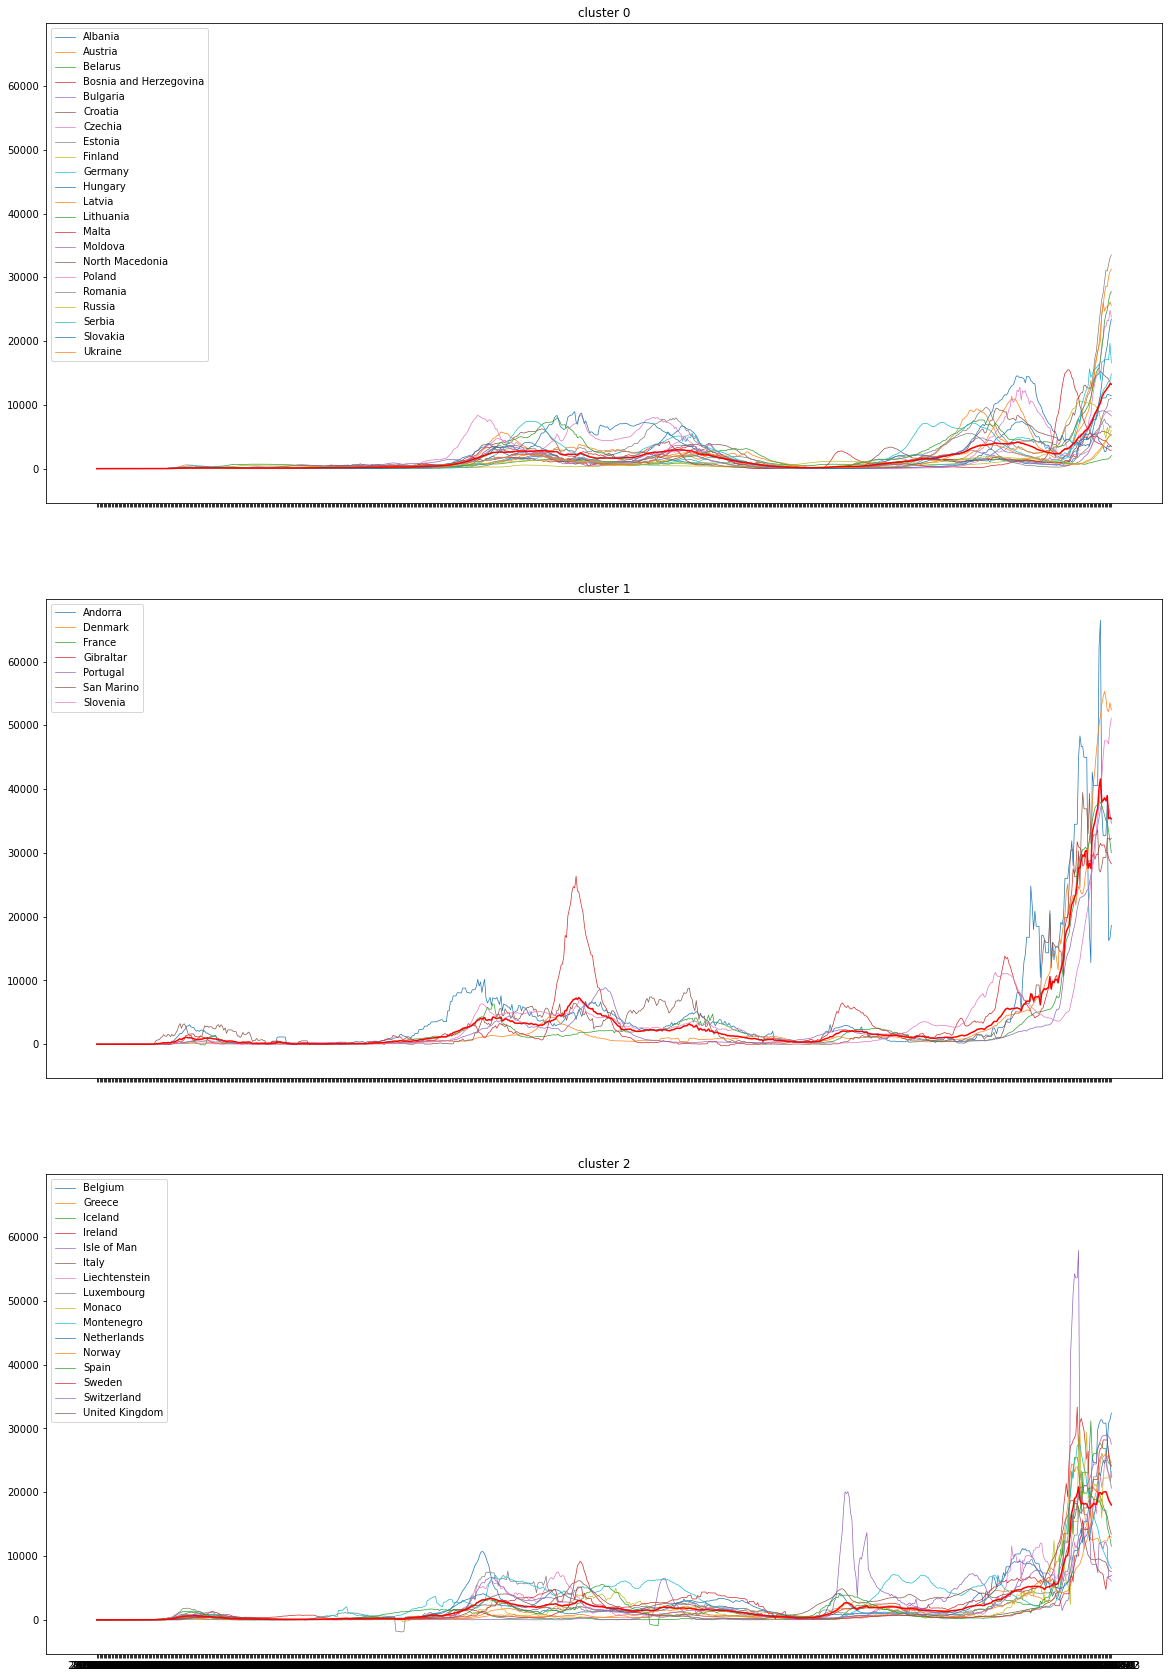

In [212]:
# plot clusterings
fig, axs = plt.subplots(n_clusters, 1, sharex=True, sharey=True, figsize=(20, 30))
centroids = []
for c in range(n_clusters):
    b = [c==label for label in km]
    axs[c].plot(dataset.iloc[b].T, linewidth=0.7, label = dataset.index[b])
    axs[c].set_title(f'cluster {c}')
    axs[c].legend(loc='upper left')
    centroid = euclidean_barycenter(dataset.iloc[b])
    centroids.append(centroid)
    axs[c].plot(centroid, color='red')


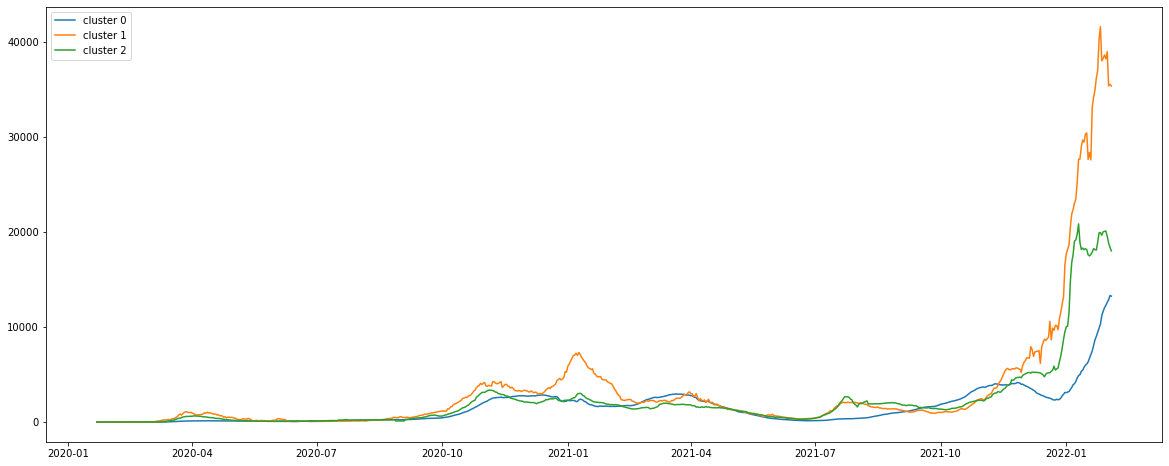

In [213]:
plt.figure(figsize=(20,8))
for i in range(len(centroids)): 
    plt.plot(dates, centroids[i], label=f'cluster {i}')
    plt.legend()


In [215]:
# iterating over hyperparameter (n_clusters, metric)
# using silhouette score to evaluate clustering
ks = range(2, 20, 1)
print(ks)
metrics = ['euclidean']
for k in ks:
    for m in metrics: 
        print('Using k =', k, m)
        model = tsc.TimeSeriesKMeans(n_clusters=k, metric=m, max_iter=50)
        labels = model.fit_predict(dataset)
        # print(labels)
        sc = tsc.silhouette_score(dataset, labels, metric=m)
        print('silhouette score:', round(sc, 4))

range(2, 20)
Using k = 2 euclidean
silhouette score: 0.3518
Using k = 3 euclidean
silhouette score: 0.2735
Using k = 4 euclidean
silhouette score: 0.2822
Using k = 5 euclidean
silhouette score: 0.3043
Using k = 6 euclidean
silhouette score: 0.2631
Using k = 7 euclidean
silhouette score: 0.2452
Using k = 8 euclidean
silhouette score: 0.2689
Using k = 9 euclidean
silhouette score: 0.2002
Using k = 10 euclidean
silhouette score: 0.2262
Using k = 11 euclidean
silhouette score: 0.2368
Using k = 12 euclidean
silhouette score: 0.1244
Using k = 13 euclidean
silhouette score: 0.219
Using k = 14 euclidean
silhouette score: 0.1639
Using k = 15 euclidean
silhouette score: 0.111
Using k = 16 euclidean
silhouette score: 0.1901
Using k = 17 euclidean
silhouette score: 0.2069
Using k = 18 euclidean
silhouette score: 0.1917
Using k = 19 euclidean
silhouette score: 0.1907
